In [1]:
# shap
# https://slundberg.github.io/shap/notebooks/gradient_explainer/Explain%20an%20Intermediate%20Layer%20of%20VGG16%20on%20ImageNet.html
''' Start up jupyter
source activate tensorflow2_latest_p37
export PATH=/opt/tljh/user/bin:$PATH
jupyter lab --no-browser --port=8888 --ip=$(hostname)
'''
import sys
print(sys.path)



['/home/ubuntu/covid-cxr/src', '/opt/tljh/user/lib/python37.zip', '/opt/tljh/user/lib/python3.7', '/opt/tljh/user/lib/python3.7/lib-dynload', '', '/home/ubuntu/.local/lib/python3.7/site-packages', '/opt/tljh/user/lib/python3.7/site-packages', '/opt/tljh/user/lib/python3.7/site-packages/IPython/extensions', '/home/ubuntu/.ipython']


To compute SHAP on a trained CNN model, we divide the CNN into two main parts: feature
extraction part and classification part (see Figure 1). The feature extraction part is used to identify
the important n-grams and outputs feature values. The classification part then looks at all
extracted features and makes the prediction. 

modelayer 0 Tensor("input_3:0", shape=(None, 224, 224, 3), dtype=float32)
modelayer 1 Tensor("input_3:0", shape=(None, 224, 224, 3), dtype=float32)
modelayer 2 Tensor("block1_conv1_2/Relu:0", shape=(None, 224, 224, 64), dtype=float32)
modelayer 3 Tensor("block1_conv2_2/Relu:0", shape=(None, 224, 224, 64), dtype=float32)
modelayer 4 Tensor("block1_pool_2/MaxPool:0", shape=(None, 112, 112, 64), dtype=float32)
modelayer 5 Tensor("block2_conv1_2/Relu:0", shape=(None, 112, 112, 128), dtype=float32)
modelayer 6 Tensor("block2_conv2_2/Relu:0", shape=(None, 112, 112, 128), dtype=float32)
modelayer 7 Tensor("block2_pool_2/MaxPool:0", shape=(None, 56, 56, 128), dtype=float32)
modelayer 8 Tensor("block3_conv1_2/Relu:0", shape=(None, 56, 56, 256), dtype=float32)
modelayer 9 Tensor("block3_conv2_2/Relu:0", shape=(None, 56, 56, 256), dtype=float32)
modelayer 10 Tensor("block3_conv3_2/Relu:0", shape=(None, 56, 56, 256), dtype=float32)
modelayer 11 Tensor("block3_pool_2/MaxPool:0", shape=(None, 28, 28

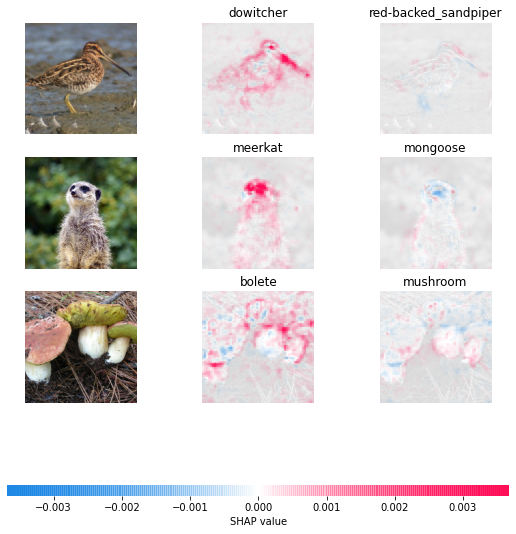

In [4]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import shap
# import keras.backend as K
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import json

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()    # don't care about y
#print(X)
#print(y)
to_explain = X[[39,41,45]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

for i in range(22):
    print("modelayer", i, model.layers[i].input)

layer = 9

e = shap.GradientExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), layer))
shap_values,indexes = e.shap_values(map2layer(to_explain, layer), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [5]:
print(type(X))
print(X.dtype)
print(X.flags)
print(X.shape)
print(X.ndim)
print(X.size)
print(X.itemsize)
print(X.flags)
print(X.strides)

<class 'numpy.ndarray'>
float32
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

(50, 224, 224, 3)
4
7526400
4
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

(602112, 2688, 12, 4)


In [ ]:
print("fname", fname)
print("y", y[1:3])
feed_dict = dict(zip([model.layers[0].input], [preprocess_input(X.copy())]))
print("feed_dict", feed_dict)
print("index name", index_names)
print("modelayer", model.layers[0].input)
print("modelayer9", model.layers[9].input)
print("modelayer-1", model.layers[-1].output)
print("map_toexplain", map2layer(to_explain, layer))
print("shapvalues", shap_values,indexes)
print("shap index", indexes)
print("preprocessinput", preprocess_input(X.copy()))


print("X",X[2])



In [ ]:
# explain how the input to the 7th layer of the model explains the top two classes
explainer = shap.GradientExplainer(
    (model.layers[layer].input, model.layers[-1].output),
    map2layer(preprocess_input(X.copy()), layer),
    local_smoothing=100
)
shap_values,indexes = explainer.shap_values(map2layer(to_explain, layer), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

The feature extraction step reduces the feature dimension to ℎ, which
is usually a relatively small number in comparison to the vocabulary dimension. Now we can use
kernel SHAP over the extracted features to get a good approximations to the exact SHAP values.